<a href="https://colab.research.google.com/github/rosshalpin/AdvancedML/blob/main/A00291183_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Student Name: Ross Halpin
## Student ID: A00291183

### Twitter Data Sentiment Analysis using tweepy to obtain tweets, then cleaning data and building an SVM and DNN with some comparison to Vader model. 

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/AdvancedML/

/
Mounted at /content/gdrive
/content/gdrive/My Drive/AdvancedML


In [ ]:
!pip install tweepy --upgrade

In [ ]:
%cd /mydrive/AdvancedML/

/content/gdrive/My Drive/AdvancedML


In [ ]:
import tweepy
import pandas as pd
import pickle

def pre_process_text(text: str) -> str:
    text = text.replace("\n", " ").replace("\t", " ") # removing newlines and tabs
    return text.strip()

def obtain_tweets(topic, max=10, limit=10):
  with open('bearer.txt', 'r') as file:
    BEARER_TOKEN = file.read().rstrip()

  client = tweepy.Client(bearer_token=BEARER_TOKEN)

  tweet_paginator = tweepy.Paginator(client.search_recent_tweets,
                                query=f"{topic} -is:retweet lang:en",
                                tweet_fields=[
                                  "created_at", 
                                  "possibly_sensitive", 
                                  "public_metrics",
                                ],
                                place_fields=[
                                  "full_name",
                                  "geo",
                                  "country",
                                  "country_code"    
                                ],
                                expansions="geo.place_id",
                                max_results=max,
                                limit=limit)

  responses = []
  for resp in tweet_paginator:
    responses.append(resp)

  found_places = {}

  for resp in responses:
    places = resp.includes.get('places')
    if places:
      for place in places:
        found_places[place.id] = place

  tweets = []

  for resp in responses:
    for tweet in resp.data:
      if tweet.geo:
        place_id = tweet.geo.get('place_id')
        coords = found_places[place_id].geo.get('bbox')
        lon = (coords[0]+coords[2])/2
        lat = (coords[1]+coords[3])/2
        new_tweet = [
            found_places[place_id].full_name,
            f"{lat:.2f},{lon:.2f}",
            tweet.created_at, 
            tweet.possibly_sensitive, 
            tweet.public_metrics.get('retweet_count'), 
            tweet.public_metrics.get('reply_count'),
            tweet.public_metrics.get('like_count'),
            tweet.public_metrics.get('quote_count'),
            pre_process_text(tweet.text),
        ]
        tweets.append(new_tweet)


  for resp in responses:
    for tweet in resp.data:
      if not tweet.geo and len(tweets) < (max*limit):
        new_tweet = [
          None,
          None,
          tweet.created_at,
          tweet.possibly_sensitive,
          tweet.public_metrics.get('retweet_count'), 
          tweet.public_metrics.get('reply_count'),
          tweet.public_metrics.get('like_count'),
          tweet.public_metrics.get('quote_count'),
          pre_process_text(tweet.text),
        ]
        tweets.append(new_tweet)

  columns = ["place", "coords", "created_at", "possibly_sensitive", "retweet_count", "reply_count", "like_count", "quote_count", "text"]
  df = pd.DataFrame(tweets, columns=columns)
  return df

In [ ]:
# df = obtain_tweets("Lewis Hamilton", 50, 50)

In [ ]:
# %cd /mydrive/AdvancedML/

In [ ]:
# import time, csv
# epoch_time = int(time.time())

# df.to_csv("tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

In [ ]:
try:
  df = pd.read_csv("tweets.1650486802.csv")
except:
  df = None

In [ ]:
df.head()

,place,coords,created_at,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,text,sentiment
0,"Port Blandford, Newfoundland and Labrador","48.36,-54.18",2022-04-20 20:18:29+00:00,False,0,0,0,0,@lemieuxdavid I’m curious where that Baba O’Re...,positive
1,"Coventry, England","52.41,-1.52",2022-04-20 17:37:06+00:00,False,4,1,43,0,Lewis Hamilton Fuji 2007… Another one of his ...,positive
2,"Tamworth, England","52.62,-1.68",2022-04-20 12:51:05+00:00,False,0,2,5,0,@MattyWTF1 Fans being openly contemptuous towa...,negative
3,"Sydney, New South Wales","-33.85,150.93",2022-04-20 09:46:10+00:00,False,0,0,0,0,@MattyWTF1 Carlos Sainz contract negotiations ...,neutral
4,Potchefstroom,"-26.26,28.00",2022-04-20 04:48:19+00:00,False,51,2,51,0,Revamp your Cv + Cover letter to attract recr...,neutral


In [ ]:
df.shape

(2500, 10)

In [ ]:
import matplotlib.pyplot as plt

def print_sentiment_breakdown(sentiments, title):
  label_colors = {
      "neutral": "lightgrey",
      "negative": "orangered",
      "positive": "lightgreen"
  }

  sent_counts = sentiments.value_counts(normalize=True) * 100
  label = sent_counts.keys()
  color= [label_colors[l] for l in label]
  plt.pie(sent_counts, labels=label, colors = color, autopct='%.0f%%')
  plt.title(title)
  plt.show()

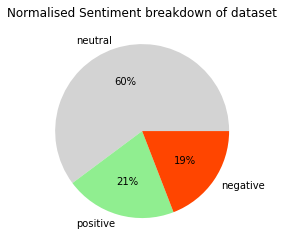

In [ ]:
print_sentiment_breakdown(df.sentiment, "Normalised Sentiment breakdown of dataset")

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')

tweet_tokenizer = TweetTokenizer()

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Cleanup

In [ ]:
import re
import string

def cleanup_data(df):

  def remove_usernames(text):
    return re.sub(r'@([^\s]+)', '', text)

  def remove_long_whitespace(text):
    text = text.strip()
    return re.sub(r'\s{2,}', '', text)

  def remove_numbers(text):
    return re.sub(r'\d+', '', text)

  def remove_hyperlinks(text):
    return re.sub(r'http\S+|www.\S+|https', '', text)

  def tokenize(input): 
    return tweet_tokenizer.tokenize(input)

  def remove_stop_words(text):
    tokens = tokenize(text)
    longest_tokens  =[x for x in tokens if len(x)>1]

    cleaned = [word for word in longest_tokens if word not in stop_words]
    return " ".join(cleaned)

  def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))


  df.text = df.text.apply(remove_usernames) # removing usernames
  df.text = df.text.apply(remove_hyperlinks) # removing hyperlinks
  df = df.drop(df.query('sentiment == "neutral"').sample(frac=.64, random_state=109).index) # evening out the number of neutral samples by random removing a percentage
  df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True) # removing any errant unicode
  df = df.drop_duplicates()
  df = df.drop_duplicates(subset='text', keep="first")
  df.text = df.text.apply(remove_long_whitespace) # removing long whitespace
  df.text = df.text.apply(remove_numbers)
  df.text = df.text.str.lower()
  # df.text = df.text.apply(remove_stop_words)
  # df.text = df.text.apply(remove_punc)

  return df

In [ ]:
df = cleanup_data(df)

In [ ]:
# import time, csv
# epoch_time = int(time.time())
# df.to_csv("cleaned_tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

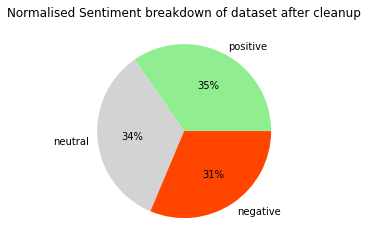

In [ ]:
print_sentiment_breakdown(df.sentiment, "Normalised Sentiment breakdown of dataset after cleanup")

In [ ]:
df.shape

(1455, 10)

# SVM Sentiment Classifier

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    _, (ax) = plt.subplots(1, 1, figsize=(20, 5))
    ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.set_xlabel("training sample")
    ax.set_ylabel("score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    # with open('svm_lc.pickle', 'wb') as handle:
    #     pickle.dump([train_sizes, train_scores, test_scores, fit_times], handle, protocol=pickle.HIGHEST_PROTOCOL)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')

tweet_tokenizer = TweetTokenizer()

def tokenize(input): 
    return tweet_tokenizer.tokenize(input)

def stemmer(input):
  snow_stemmer = SnowballStemmer("english")
  return (snow_stemmer.stem(word) for word in input)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, random_state=431, shuffle=True)

vectorizer = TfidfVectorizer(
    lowercase = True,
    max_features=500
)


X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

clf = svm.SVC(
    kernel='linear',
)
clf.fit(X_train_vectors, y_train)
y_pred = clf.predict(X_test_vectors)

report = classification_report(y_test, y_pred, output_dict=True)
print('accuracy: ', report['accuracy'])
print('macro avg: ', report['macro avg'])
print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral ', report['neutral'])

accuracy:  0.6164383561643836
macro avg:  {'precision': 0.6193964765393337, 'recall': 0.6170178216214022, 'f1-score': 0.617932034961738, 'support': 146}
positive:  {'precision': 0.6530612244897959, 'recall': 0.6274509803921569, 'f1-score': 0.64, 'support': 51}
negative:  {'precision': 0.6666666666666666, 'recall': 0.6521739130434783, 'f1-score': 0.6593406593406593, 'support': 46}
neutral  {'precision': 0.5384615384615384, 'recall': 0.5714285714285714, 'f1-score': 0.5544554455445544, 'support': 49}


In [ ]:
# with open('svm.pickle', 'wb') as handle:
#     pickle.dump([y_test, y_pred], handle, protocol=pickle.HIGHEST_PROTOCOL)

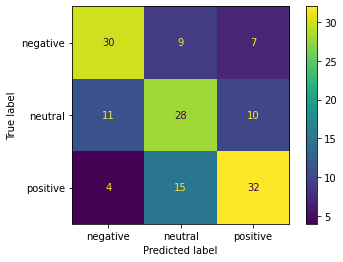

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

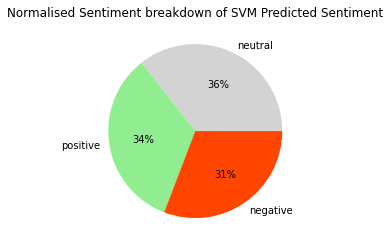

In [ ]:
pred_df = pd.DataFrame(y_pred)[0]
print_sentiment_breakdown(pred_df, "Normalised Sentiment breakdown of SVM Predicted Sentiment")

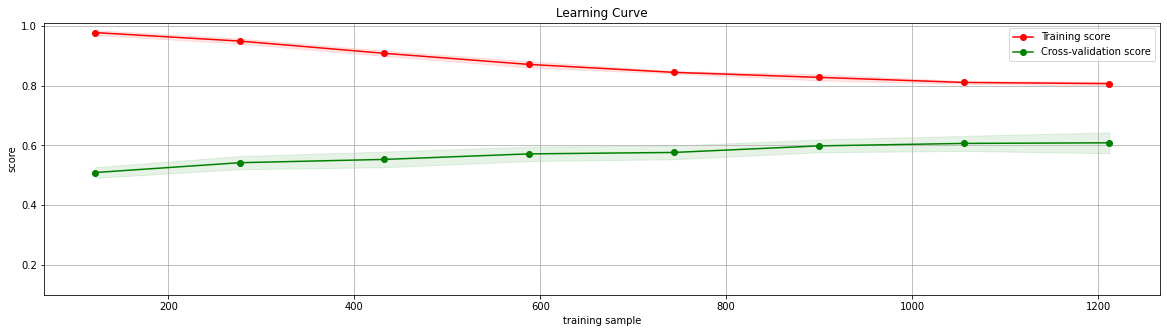

In [ ]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)

plot_learning_curve(
    clf, 
    "Learning Curve", 
    X=vectorizer.fit_transform(df.text), 
    y=df.sentiment,
    ylim=(0.1, 1.01), 
    cv=folds, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

plt.show()

# Vader Sentiment Analysis

In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  analysis = analyzer.polarity_scores(text)
  score = analysis["compound"]
  if score >= 0.05:
    return "positive"
  if score > -0.05 and score < 0.05:
    return "neutral"
  if score <= -0.05:
    return "negative"

vader_df = pd.DataFrame(X_test).apply(get_sentiment, axis=1)

vader_report = classification_report(vader_df, y_test, output_dict=True)
print('accuracy: ', vader_report['accuracy'])
print('macro avg: ', vader_report['macro avg'])
print('positive: ', vader_report['positive'])
print('negative: ', vader_report['negative'])
print('neutral ', vader_report['neutral'])

accuracy:  0.636986301369863
macro avg:  {'precision': 0.634137713056237, 'recall': 0.6466060842941829, 'f1-score': 0.6299058949422466, 'support': 146}
positive:  {'precision': 0.803921568627451, 'recall': 0.6029411764705882, 'f1-score': 0.6890756302521008, 'support': 68}
negative:  {'precision': 0.6086956521739131, 'recall': 0.6511627906976745, 'f1-score': 0.6292134831460675, 'support': 43}
neutral  {'precision': 0.4897959183673469, 'recall': 0.6857142857142857, 'f1-score': 0.5714285714285715, 'support': 35}


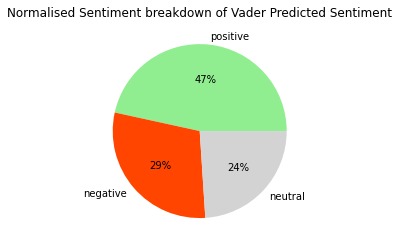

In [ ]:
print_sentiment_breakdown(vader_df, "Normalised Sentiment breakdown of Vader Predicted Sentiment")

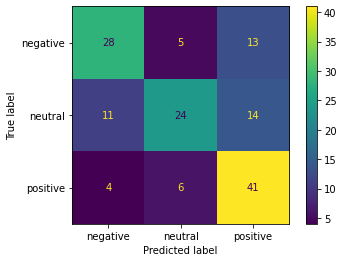

In [ ]:
cm = confusion_matrix(y_test, vader_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

In [ ]:
vader_df = vader_df.reset_index(drop=True)
vader_df.eq(pred_df).mean() * 100

43.15068493150685

# Comparing SVM and Vader on a different topic

In [ ]:
# pol_df = obtain_tweets("Bernie Sanders", 25, 20)

# epoch_time = int(time.time())

# df.to_csv("pol_tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

In [ ]:
pol_df = pd.read_csv("pol_tweets.1650715759.csv")

In [ ]:
pol_df = cleanup_data(pol_df)

In [ ]:
pol_df.sample(10)

,place,coords,created_at,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,text,sentiment
433,NaN,NaN,2022-04-22 21:07:32+00:00,False,0,1,0,0,"i do that too, i worked may ass off for bernie...",negative
60,NaN,NaN,2022-04-22 22:18:12+00:00,False,0,0,0,0,bernie sanders torches congress for considerin...,negative
385,NaN,NaN,2022-04-22 21:16:51+00:00,False,0,0,0,0,here is bernie sanders' roadmap to victory in ...,positive
3,NaN,NaN,2022-04-22 22:40:13+00:00,False,0,0,0,0,bernie sanders ran on this and you idiots didn...,negative
440,NaN,NaN,2022-04-22 21:05:51+00:00,False,0,0,1,0,bernie sanders urges congress to reject bailou...,neutral
376,NaN,NaN,2022-04-22 21:17:34+00:00,False,0,0,0,0,it's bernie sanders),neutral
439,NaN,NaN,2022-04-22 21:05:59+00:00,False,0,0,0,0,"and biden, your party isnt my grandparents dem...",negative
16,NaN,NaN,2022-04-22 22:33:19+00:00,False,0,0,0,0,bernie sanders urges congress to reject bailou...,neutral
73,NaN,NaN,2022-04-22 22:15:03+00:00,False,1,0,0,0,. andto hold rally with staten island amazon w...,neutral
51,NaN,NaN,2022-04-22 22:21:14+00:00,False,0,0,0,0,"d,h,m,n keylbj will always rule the pantheon a...",neutral


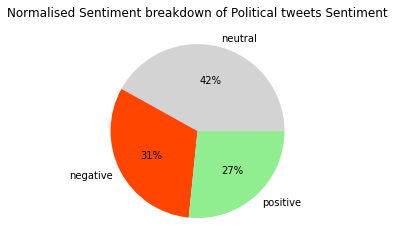

In [ ]:
print_sentiment_breakdown(pol_df.sentiment, "Normalised Sentiment breakdown of Political tweets Sentiment")

In [ ]:
pol_df.shape

(124, 10)

### Vader Sentiment Analysis on Political topic

accuracy:  0.5403225806451613
macro avg:  {'precision': 0.527972027972028, 'recall': 0.5617050298380222, 'f1-score': 0.5263696876600102, 'support': 124}
positive:  {'precision': 0.5454545454545454, 'recall': 0.35294117647058826, 'f1-score': 0.42857142857142855, 'support': 51}
negative:  {'precision': 0.38461538461538464, 'recall': 0.6521739130434783, 'f1-score': 0.4838709677419355, 'support': 23}
neutral  {'precision': 0.6538461538461539, 'recall': 0.68, 'f1-score': 0.6666666666666666, 'support': 50}


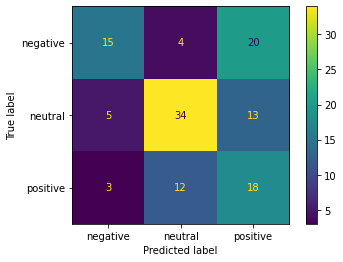

In [ ]:
def get_sentiment(text):
  analysis = analyzer.polarity_scores(text)
  score = analysis["compound"]
  if score >= 0.05:
    return "positive"
  if score > -0.05 and score < 0.05:
    return "neutral"
  if score <= -0.05:
    return "negative"

vader_pol_df = pd.DataFrame(pol_df.text).apply(get_sentiment, axis=1)

vader_pol_report = classification_report(vader_pol_df, pol_df.sentiment, output_dict=True)
print('accuracy: ', vader_pol_report['accuracy'])
print('macro avg: ', vader_pol_report['macro avg'])
print('positive: ', vader_pol_report['positive'])
print('negative: ', vader_pol_report['negative'])
print('neutral ', vader_pol_report['neutral'])

cm = confusion_matrix(pol_df.sentiment, vader_pol_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

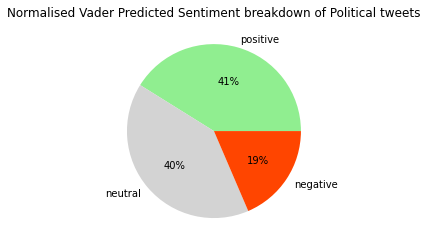

In [ ]:
print_sentiment_breakdown(vader_pol_df, "Normalised Vader Predicted Sentiment breakdown of Political tweets")

### SVM Sentiment Analysis on Political Topic

In [ ]:
pol_vectors = vectorizer.transform(pol_df.text)

In [ ]:
pol_vectors.shape

(124, 500)

accuracy:  0.49193548387096775
macro avg:  {'precision': 0.4485169610316793, 'recall': 0.4601787101787102, 'f1-score': 0.4522988505747126, 'support': 124}
positive:  {'precision': 0.24, 'recall': 0.18181818181818182, 'f1-score': 0.20689655172413793, 'support': 33}
negative:  {'precision': 0.5365853658536586, 'recall': 0.5641025641025641, 'f1-score': 0.55, 'support': 39}
neutral  {'precision': 0.5689655172413793, 'recall': 0.6346153846153846, 'f1-score': 0.6, 'support': 52}


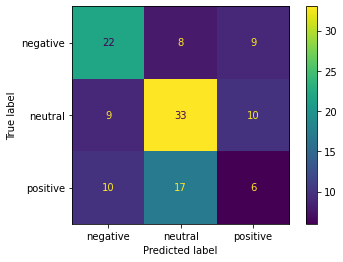

In [ ]:
svm_pol_pred = clf.predict(pol_vectors)

svm_pol_report = classification_report(pol_df.sentiment, svm_pol_pred, output_dict=True)
print('accuracy: ', svm_pol_report['accuracy'])
print('macro avg: ', svm_pol_report['macro avg'])
print('positive: ', svm_pol_report['positive'])
print('negative: ', svm_pol_report['negative'])
print('neutral ', svm_pol_report['neutral'])

cm = confusion_matrix(pol_df.sentiment, svm_pol_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

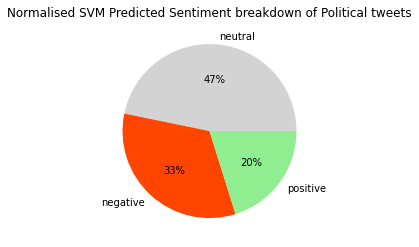

In [ ]:
svm_pol_df = pd.DataFrame(svm_pol_pred)[0]

print_sentiment_breakdown(svm_pol_df, "Normalised SVM Predicted Sentiment breakdown of Political tweets")

For the first topic, Vader and the SVM only agrred 43% of the time. 

Its clear that my SVM model does not generalise well to unseen data of a different topic, in particular it struggles to identify `positive` sentiment.

Vader is able to generalise better but only performs marginally better accuracy wise in the political topic, with `0.54` accuracy against `0.49` accuracy of the SVM. 

The SVM yields a `positive` sentiment f1-score of only `0.20` whereas Vader is much better at `0.42`. Both models are performing poorly here but Vader is triumphant. 

Both models perform quiet well at identifying `neutral` sentiment.



# Deep Neural Network Sentiment Analysis

In [ ]:
df = pd.read_csv("tweets.1650486802.csv")
df = cleanup_data(df)

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from numpy.random import seed
seed(1)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


Y = pd.get_dummies(df.sentiment).values

max_features = 90

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df.text)

X = pad_sequences(tokenizer.texts_to_sequences(df.text))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=613, shuffle=True)

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.callbacks import History 
history = History()

embed_dim = 15
lstm_out = 5


model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 15)            1350      
                                                                 
 lstm (LSTM)                 (None, 5)                 420       
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
Total params: 1,788
Trainable params: 1,788
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# try:
#   with open('history.pickle', 'rb') as handle:
#     history2 = pickle.load(handle)
# except:
#   history2 = None

history2 = None

In [ ]:
if not history2:
  history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 40, verbose = 2, callbacks=[history, model_checkpoint_callback])

Epoch 1/40
41/41 - 32s - loss: 1.0929 - accuracy: 0.3873 - val_loss: 1.0890 - val_accuracy: 0.4315 - 32s/epoch - 790ms/step
Epoch 2/40
41/41 - 17s - loss: 1.0737 - accuracy: 0.4423 - val_loss: 1.0720 - val_accuracy: 0.4795 - 17s/epoch - 409ms/step
Epoch 3/40
41/41 - 10s - loss: 1.0430 - accuracy: 0.4752 - val_loss: 1.0493 - val_accuracy: 0.3904 - 10s/epoch - 248ms/step
Epoch 4/40
41/41 - 10s - loss: 1.0204 - accuracy: 0.4927 - val_loss: 1.0405 - val_accuracy: 0.3973 - 10s/epoch - 254ms/step
Epoch 5/40
41/41 - 10s - loss: 1.0116 - accuracy: 0.4866 - val_loss: 1.0176 - val_accuracy: 0.4658 - 10s/epoch - 247ms/step
Epoch 6/40
41/41 - 10s - loss: 0.9981 - accuracy: 0.4996 - val_loss: 1.0191 - val_accuracy: 0.4247 - 10s/epoch - 245ms/step
Epoch 7/40
41/41 - 10s - loss: 0.9897 - accuracy: 0.5118 - val_loss: 1.0048 - val_accuracy: 0.4795 - 10s/epoch - 244ms/step
Epoch 8/40
41/41 - 10s - loss: 0.9818 - accuracy: 0.5164 - val_loss: 0.9939 - val_accuracy: 0.4795 - 10s/epoch - 242ms/step
Epoch 9/

In [ ]:
# import pickle

# with open('history.pickle', 'wb') as handle:
#     pickle.dump(history2.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.load_weights(checkpoint_filepath)

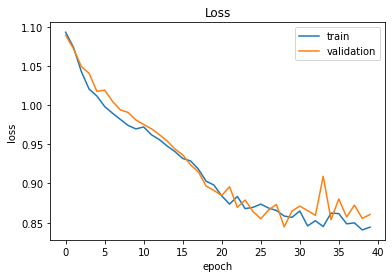

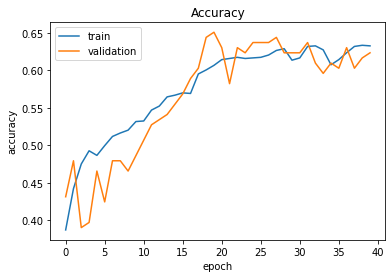

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
import operator
# negative, neutral, positive

def get_sentiment(values):
  max_index, max_value = max(enumerate(values), key=operator.itemgetter(1))
  if max_index == 0:
    return "negative"
  if max_index == 1:
    return "neutral"
  if max_index == 2:
    return "positive"
  return "mixed"

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_sen = pd.DataFrame([get_sentiment(vals) for vals in y_pred])[0]
y_test_sen = pd.DataFrame([get_sentiment(vals) for vals in y_test])[0]

In [ ]:
# with open('dnn.pickle', 'wb') as handle:
#     pickle.dump([y_test_sen, y_pred_sen], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
dnn_report = classification_report(y_test_sen, y_pred_sen, output_dict=True)
print('accuracy: ', dnn_report['accuracy'])
print('macro avg: ', dnn_report['macro avg'])
print('positive: ', dnn_report['positive'])
print('negative: ', dnn_report['negative'])
print('neutral ', dnn_report['neutral'])

accuracy:  0.6506849315068494
macro avg:  {'precision': 0.6520376175548589, 'recall': 0.6521606869698234, 'f1-score': 0.6486673868997603, 'support': 146}
positive:  {'precision': 0.6379310344827587, 'recall': 0.7708333333333334, 'f1-score': 0.69811320754717, 'support': 48}
negative:  {'precision': 0.6590909090909091, 'recall': 0.5686274509803921, 'f1-score': 0.6105263157894737, 'support': 51}
neutral  {'precision': 0.6590909090909091, 'recall': 0.6170212765957447, 'f1-score': 0.6373626373626374, 'support': 47}


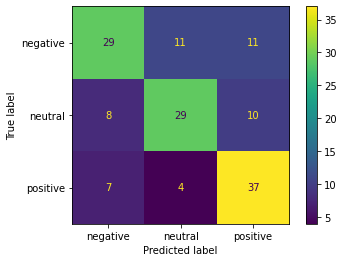

In [ ]:
cm = confusion_matrix(y_test_sen, y_pred_sen)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

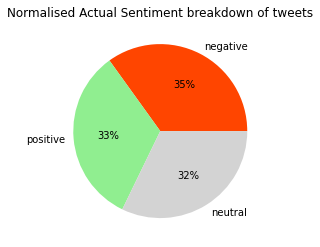

In [ ]:
print_sentiment_breakdown(y_test_sen, "Normalised Actual Sentiment breakdown of tweets")

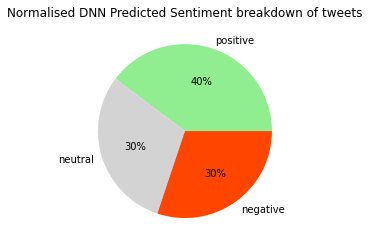

In [ ]:
print_sentiment_breakdown(y_pred_sen, "Normalised DNN Predicted Sentiment breakdown of tweets")

Performance report on same topic:

SVM:

```
accuracy:  0.6164383561643836
macro avg:  {'precision': 0.6193964765393337, 'recall': 0.6170178216214022, 'f1-score': 0.617932034961738, 'support': 146}
positive:  {'precision': 0.6530612244897959, 'recall': 0.6274509803921569, 'f1-score': 0.64, 'support': 51}
negative:  {'precision': 0.6666666666666666, 'recall': 0.6521739130434783, 'f1-score': 0.6593406593406593, 'support': 46}
neutral  {'precision': 0.5384615384615384, 'recall': 0.5714285714285714, 'f1-score': 0.5544554455445544, 'support': 49}
```

Vader:

```
accuracy:  0.636986301369863
macro avg:  {'precision': 0.634137713056237, 'recall': 0.6466060842941829, 'f1-score': 0.6299058949422466, 'support': 146}
positive:  {'precision': 0.803921568627451, 'recall': 0.6029411764705882, 'f1-score': 0.6890756302521008, 'support': 68}
negative:  {'precision': 0.6086956521739131, 'recall': 0.6511627906976745, 'f1-score': 0.6292134831460675, 'support': 43}
neutral  {'precision': 0.4897959183673469, 'recall': 0.6857142857142857, 'f1-score': 0.5714285714285715, 'support': 35}
```

DNN:

```
accuracy:  0.6506849315068494
macro avg:  {'precision': 0.6520376175548589, 'recall': 0.6521606869698234, 'f1-score': 0.6486673868997603, 'support': 146}
positive:  {'precision': 0.6379310344827587, 'recall': 0.7708333333333334, 'f1-score': 0.69811320754717, 'support': 48}
negative:  {'precision': 0.6590909090909091, 'recall': 0.5686274509803921, 'f1-score': 0.6105263157894737, 'support': 51}
neutral  {'precision': 0.6590909090909091, 'recall': 0.6170212765957447, 'f1-score': 0.6373626373626374, 'support': 47}
```

As we can see above the models perform quite similarly. The SVM struggles slightly more with `neutral` sentiment, Vader performs much better with `positive` sentiment but struggles the most with `neutral`, while the DNN appears to perform the best overall. 